<a href="https://colab.research.google.com/github/Shehab89/Project1/blob/main/SG1_Al_Masri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Comparative Analysis of Rule-Based and Machine Learning Approaches in Sentiment Analysis for Movie Reviews #





Shehab Ali Qasem Al-Masri – 4338707 - Group 1 - Instructor: Dr. Jing Zeng

In [29]:
#import necessary libraries
import pandas as pd

import string

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#splitting datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#regex
import re

#NLP
import nltk
from nltk.tokenize import word_tokenize #tokenization
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

import spacy
from spacy.symbols import nsubj, VERB
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud

#Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report #performance report

#VADER
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
!pip install beautifulsoup4
from bs4 import BeautifulSoup


The used dataset is IMDB_MovieReviewDataset which was originally used Maas et al. (2011). The dataset includes more than 50k reviews and the sentiment label eather positive or negative.

In [31]:
# read data
'''
InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
'''

reviews_df = pd.read_csv("/content/drive/MyDrive/INFOMTMA/IMDB_MovieReviewDataset.csv")
reviews_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
57878,I thought this movie did a down right good job...,positive
57879,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
57880,I am a Catholic taught in parochial elementary...,negative
57881,I'm going to have to disagree with the previou...,negative


## Exploratery data analysis

In [32]:
reviews_df.isnull().values.any()

False

In [33]:
# overview dataset
reviews_df.describe()

,review,sentiment
count,57883,57883
unique,49592,2
top,Loved today's show!!! It was a variety and not...,negative
freq,7,28962


In [34]:
# count negative and positive reviews in the dataset
reviews_df['sentiment'].value_counts()

negative    28962
positive    28921
Name: sentiment, dtype: int64

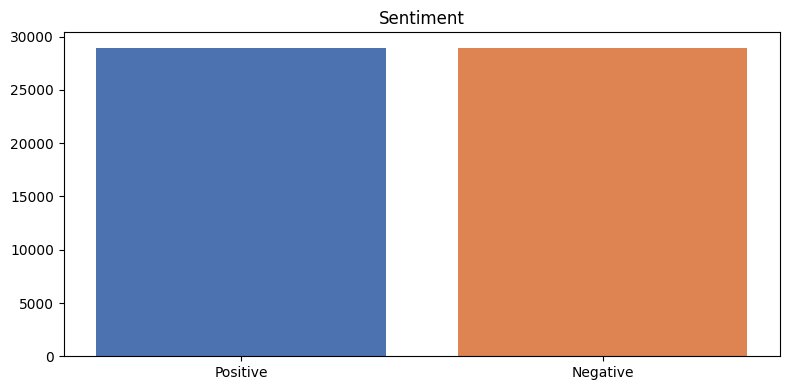

In [35]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=reviews_df.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

As we can see, the number of positive and negative reviews almost equal and there are no missing values.

In [36]:
#review the sample before preprocessing
reviews_df.iloc[1200,0]

"An odd, willfully skewed biopic of Dyan Thomas in which we hear little more than a dozen lines of his poetry. Instead we have to endure a raw character exposée seen through the prism of his proto-bigamous relationship with wife (Sienna Miller) and childhood love (Keira Knightley). Matthew Rhys plays Thomas with sufficient charm to inoculate us against his otherwise repellent self-interest and Cillian Murphy makes up the persistently tense lovetet.<br /><br />The film never seems to decide on where it's going. There's no arc so much as a viaduct from one end of the war to the other. Maybury seems much more interested in his two female leads (who wouldn't!?) than in the man who brings them together and then divides them. Miller is the choice of the two (I found Knightley competent at best but then I have never found her sympathetic) but they both offer dreadfully inconsistent Welsh accents. Other funny decisions include too much for the inconsequential character of William (Murphy), art

## Data preprocessing

### Data cleaning
In this part, we are going to clean the text from punctuation, numbers and stopwords,

In [37]:
def text_cleaning(text):
  text = text.lower() #convert all the text into lowercase
  text = text.translate(str.maketrans(' ', ' ', string.punctuation)) #remove punctuation
  text = re.sub(r'\d+', '', text) #remove numbers
  stop_words = set(stopwords.words("english"))
  word_tokens = word_tokenize(text)
  filtered_text = [word for word in word_tokens if word not in stop_words] #remove english stop words

  text = " ".join(text.split())
  #remove html tags
  html=BeautifulSoup(text, 'html.parser')
  text = html.get_text(separator=' ')
  # remove — and ’
  text = re.sub("—", " ", text)
  text = re.sub("’", " ", text)
  text = re.sub("–", " ", text)
  text = re.sub("…", " ", text)
  text = re.sub("“", " ", text)
  text = re.sub("”", " ", text)
  text = re.sub("  ", " ", text)

  #remove br tags
  text = re.sub(r'<br\s*/?>\s*<br\s*/?>', '', text)
  text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
  text = re.sub(r'\s*br\s*', ' ', text) #after cleaning html tags "br" still there!!

  return text


In [38]:

#Apply text_cleaining function on reviews and store it on review_cl column
reviews_df['review_cl'] = reviews_df['review'].apply(lambda x:text_cleaning(x))

In [39]:
#review the sample after preprocessing
reviews_df.iloc[1200,2]

'an odd willfully skewed biopic of dyan thomas in which we hear little more than a dozen line of his poetry instead we have to endure a raw character exposée seen through the prism of his protobigamous relationship with wife sienna miller and childhood love keira knightley matthew rhys play thomas with sufficient charm to inoculate u against his otherwise repellent selfinterest and cillian murphy make up the persistently tense lovetet  the film never seems to decide on where it going there no arc so much a a viaduct from one end of the war to the other maybury seems much more interested in his two female lead who wouldnt than in the man who ings them together and then divide them miller is the choice of the two i found knightley competent at best but then i have never found her sympathetic but they both offer dreadfully inconsistent welsh accent other funny decision include too much for the inconsequential character of william murphy arty production eg double crossfades that is neither

### Train/ Text split
In this part I will split the dataset into train and test datasets using the regular method as we have imbalanced dataset as we saw in the above analysis. However, train data will take 80% of the dataset and the rest will be assigned to the test dataset.

In [40]:
sentiment = reviews_df['sentiment'].values
reviews = reviews_df['review_cl']
sentiment

array(['positive', 'positive', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [41]:
#split the dataset into train (0.8) and test (0.2) datasets
rev_train, rev_test, sent_train,sent_test = train_test_split(reviews, sentiment, test_size=0.2, random_state=34)
#random_state parameter takes an arbitrary value that aims to ensure that if we run the code multiple times, wee'll get the same split each time.

In [42]:
rev_train.head()

47790    and ethel merman buff too will love her loud b...
5534     it new year eve a copkiller in the form of lau...
1679     wow whats this on the video rental store shelf...
15663    lorenzo lama star a jack solider kelly an exvi...
24434    there only one thing im going to say about cat...
Name: review_cl, dtype: object

In [43]:
sent_train

array(['negative', 'negative', 'negative', ..., 'positive', 'negative',
       'negative'], dtype=object)

### Vectorization
Before applying machine learning approach, I need to convert the text into numerical vectors. To achieve that, I will use TfIDF method (term frequency–inverse document frequency).

In [44]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.4, norm='l2')

tfidf.fit(rev_train) # create the vocabulary

rev_train_tf = tfidf.transform(rev_train)
rev_test_tf = tfidf.transform(rev_test)

In [45]:
#vec = pd.DataFrame(data = rev_train_tf.toarray(), columns=tfidf.get_feature_names_out())

## Machine Learning Approach

The first approach is machine learning approach. In this part, I am going to expermint several machine learning classifiers and evaluate the performance.

#### Decision Tree Classifier:
Decision trees is a machine learning clasifier that uses yes or no questions to build a tree of decisions.


In [46]:

dec_tree = DecisionTreeClassifier()
#fit the model
dec_tree.fit(rev_train_tf, sent_train)
#get the predictions
sent_pred_dt = dec_tree.predict(rev_test_tf)

print(classification_report(sent_test, sent_pred_dt,
                          target_names=['positive','negative'], digits=4))

              precision    recall  f1-score   support

    positive     0.7769    0.7765    0.7767      5794
    negative     0.7762    0.7766    0.7764      5783

    accuracy                         0.7765     11577
   macro avg     0.7765    0.7765    0.7765     11577
weighted avg     0.7765    0.7765    0.7765     11577



I assume that the model may face challenges due to the complexity and curse of dimensionality

#### Logistic regression:
Logistic regression is a machine learning technique often used for binary classification tasks, including text classification, which matches the purpose of our task. In text classification, the goal is to assign a specific piece of text to one or more predefined categories.

In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, tol=1e-4)
lr.fit(rev_train_tf, sent_train)

sent_pred_lr = lr.predict(rev_test_tf)

print(classification_report(sent_test, sent_pred_lr,
                          target_names=['positive','negative'], digits=4))

              precision    recall  f1-score   support

    positive     0.9122    0.8897    0.9008      5794
    negative     0.8922    0.9142    0.9031      5783

    accuracy                         0.9020     11577
   macro avg     0.9022    0.9020    0.9019     11577
weighted avg     0.9022    0.9020    0.9019     11577



The performance is better. That may be due to the nature of logistic regression classifier.

## Rule-Base Model

### VADER Model:

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon-based model that is used in sentiment analysis. The output includes four values between -1 and 1 for Negative, Neutral, Positive, and Compound sentiment.

```
{'neg': 0.506, 'neu': 0.494, 'pos': 0.0, 'compound': -0.8478}
```
In this task, our target is to predict either negative or positive. Thus, I will assume a compound value that equals or exceeds 0 positive, otherwise negative.

In [48]:
#first, I will preprocess the whole reviews using text_cleaning function and prepare it for VADER model
reviews_df['review_vd'] = reviews_df['review'].apply(lambda x:text_cleaning(x))
reviews_df

,review,sentiment,review_cl,review_vd
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewer ha mentioned that af...,one of the other reviewer ha mentioned that af...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tec...,a wonderful little production the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this wa a wonderful way to spend tim...,i thought this wa a wonderful way to spend tim...
3,Basically there's a family where a little boy ...,negative,basically there a family where a little boy ja...,basically there a family where a little boy ja...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...
...,...,...,...,...
57878,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,i thought this movie did a down right good job...
57879,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...
57880,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,i am a catholic taught in parochial elementary...
57881,I'm going to have to disagree with the previou...,negative,im going to have to disagree with the previous...,im going to have to disagree with the previous...


In [68]:
#sent_pred_vd =[]
vd = SentimentIntensityAnalyzer()

reviews_df['vader_sentiment'] = reviews_df['review_vd'].apply(lambda x: 'positive' if vd.polarity_scores(x)['compound'] > 0 else 'negative')
sent_pred_vd = reviews_df['vader_sentiment']
print(classification_report(sentiment, sent_pred_vd,
                          target_names=['positive','negative'], digits=4))

              precision    recall  f1-score   support

    positive     0.8021    0.5101    0.6236     28962
    negative     0.6405    0.8739    0.7392     28921

    accuracy                         0.6919     57883
   macro avg     0.7213    0.6920    0.6814     57883
weighted avg     0.7213    0.6919    0.6814     57883



In [69]:
reviews_df

,review,sentiment,review_cl,review_vd,vader_sentiment
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewer ha mentioned that af...,one of the other reviewer ha mentioned that af...,negative
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tec...,a wonderful little production the filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive,i thought this wa a wonderful way to spend tim...,i thought this wa a wonderful way to spend tim...,positive
3,Basically there's a family where a little boy ...,negative,basically there a family where a little boy ja...,basically there a family where a little boy ja...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,positive
...,...,...,...,...,...
57878,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,i thought this movie did a down right good job...,positive
57879,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...,negative
57880,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,i am a catholic taught in parochial elementary...,negative
57881,I'm going to have to disagree with the previou...,negative,im going to have to disagree with the previous...,im going to have to disagree with the previous...,negative


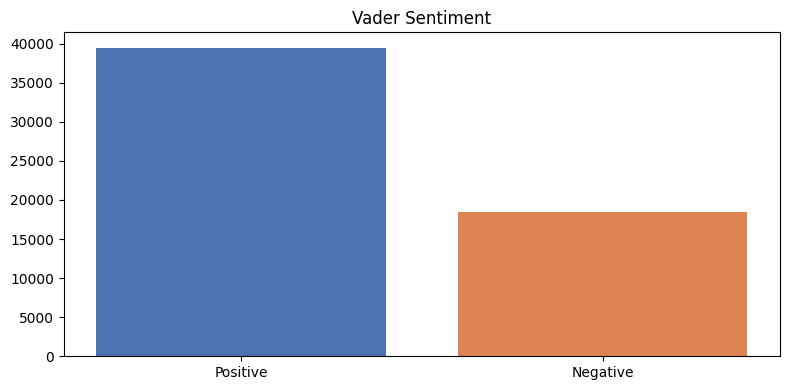

In [70]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=reviews_df.value_counts(['vader_sentiment']),
        color=colors[:2])
plt.title('Vader Sentiment')
plt.savefig('vader_sentiment.png')
plt.show()

We can see that number of negative sentiments has beedn decreased compared to original dataset.